In [15]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from pandas.plotting import register_matplotlib_converters

# make sure that pandas datatype can be used in matplotlib plots without casting
register_matplotlib_converters()

# graphics customization
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 1.5
darkgrey = '#3A3A3A'
lightgrey = '#414141'
barblue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
plt.rcParams['text.color'] = darkgrey
plt.rcParams['axes.labelcolor'] = darkgrey
plt.rcParams['xtick.color'] = lightgrey
plt.rcParams['ytick.color'] = lightgrey



In [2]:
kanban_data = pd.read_csv("MK_data.csv",usecols=['Done', 'Type'], parse_dates=['Done']).dropna()
kanban_data.head(1)

,Done,Type
0,2023-09-26,Story


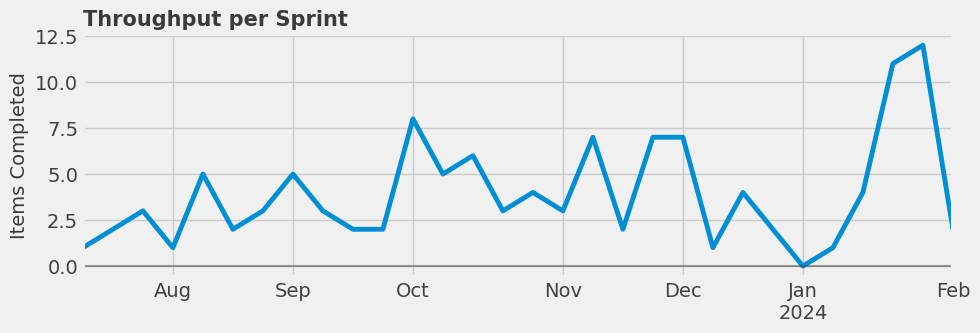

In [28]:
# Мы суммируем выполненные работы за спринт (TASK+BUG+STORY)
# и выводим данные о производительности за спринт
# чтобы получить обзор результата.

throughput = pd.crosstab(
    kanban_data.Done, kanban_data.Type, colnames=[None]).reset_index()
throughput['Throughput'] = throughput.Bug + throughput.Story + throughput.Task
date_range = pd.date_range(
    start=throughput.Done.min(), end=throughput.Done.max())
throughput = throughput.set_index('Done').reindex(
    date_range).fillna(0).astype(int).rename_axis('Date')
throughput_per_week = pd.DataFrame(
    throughput['Throughput'].resample('W-Mon').sum()).reset_index()
ax = throughput_per_week.plot(
    x='Date', y='Throughput', linewidth=3.5, figsize=(10, 3), legend=None)
ax.set_title("Throughput per Sprint", loc='left', fontdict={
             'fontsize': 15, 'fontweight': 'semibold'})
ax.set_xlabel('')
ax.set_ylabel('Items Completed')
ax.axhline(y=0, color=lightgrey, alpha=.5)

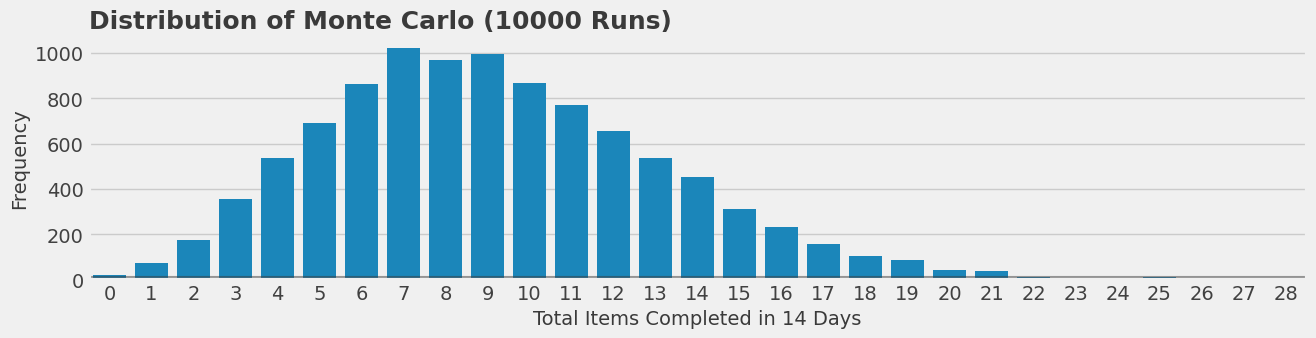

In [22]:
### PARAMETERS ####
LAST_DAYS = 150 # временной интервал 
SIMULATION_DAYS = 14 # прололжительность спринта
SIMULATIONS = 10000 # количество итераций 

dataset = throughput[['Throughput']].tail(LAST_DAYS).reset_index(drop=True)
samples = [dataset.sample(n=SIMULATION_DAYS, replace=True).sum(
).Throughput for i in range(SIMULATIONS)]
samples = pd.DataFrame(samples, columns=['Items'])
distribution = samples.groupby(['Items']).size().reset_index(name='Frequency')
plt.figure(figsize=(14, 3))
#ax = sns.barplot(x='Items', y='Frequency', data=distribution, color=barblue)
ax.set_title(f"Distribution of Monte Carlo ({SIMULATIONS} Iterations)", loc='left',
             fontdict={'size': 18, 'weight': 'semibold'})
ax.set_xlabel(f"Total Items Completed in {SIMULATION_DAYS} Days")
ax.set_ylabel('Frequency')
ax.axhline(y=SIMULATIONS*0.001, color=darkgrey, alpha=.5)

C:\Users\morgu\AppData\Local\Temp\ipykernel_7980\1170111061.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels=['0', '20', '40', '60', '80', '100%']);


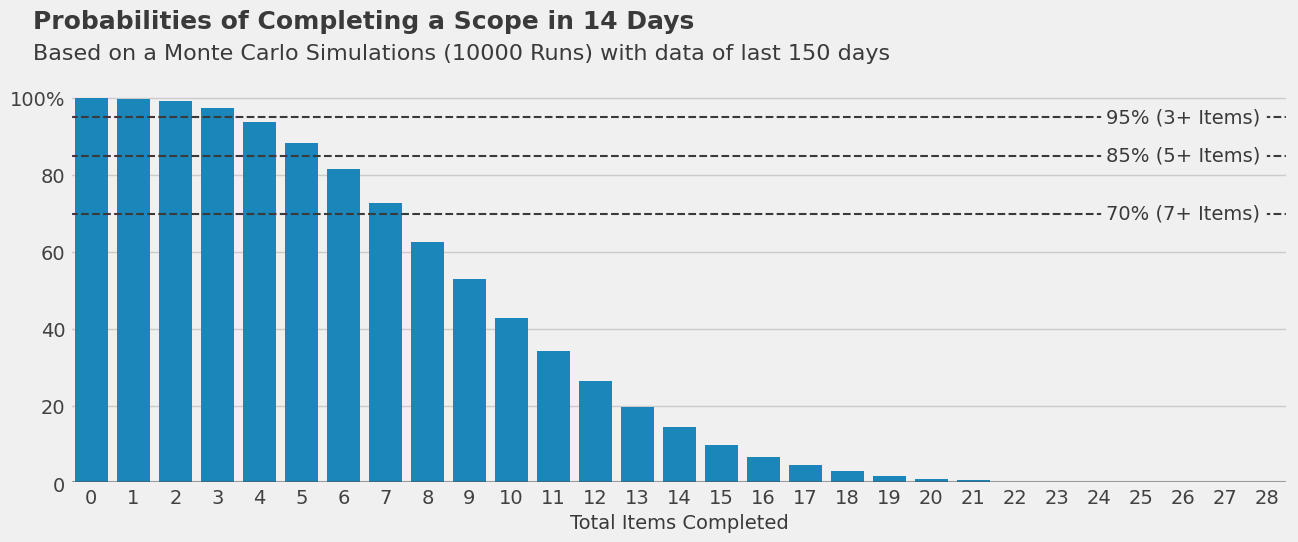

In [27]:
distribution = distribution.sort_index(ascending=False)
distribution['Probability'] = 100 * \
    distribution.Frequency.cumsum()/distribution.Frequency.sum()
plt.figure(figsize=(14, 5))
#ax = sns.barplot(x='Items', y='Probability', data=distribution, color=barblue)
ax.text(x=-1.4, y=118,
        s=f"Probabilities of Completing a Scope in {SIMULATION_DAYS} Days", fontsize=18, fontweight='semibold')
ax.text(x=-1.4, y=110,
        s=f"Based on a Monte Carlo Simulations ({SIMULATIONS} Runs) with data of last {LAST_DAYS} days", fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('Total Items Completed')
ax.axhline(y=0.5, color=darkgrey, alpha=.5)
ax.axhline(y=70, color=darkgrey, linestyle='--')
ax.axhline(y=85, color=darkgrey, linestyle='--')
ax.axhline(y=95, color=darkgrey, linestyle='--')
label_xpos = distribution['Items'].max()-2
ax.text(y=70, x=label_xpos, s=f'70%% (%d+ Items)' % samples.Items.quantile(0.3),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=label_xpos, s=f'85%% (%d+ Items)' % samples.Items.quantile(0.15),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=label_xpos, s=f'95%% (%d+ Items)' % samples.Items.quantile(0.05),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.set_yticklabels(labels=['0', '20', '40', '60', '80', '100%'])